In [1]:
#Basic imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from collections import Counter

#Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize

#Import for interactive plots
import plotly.graph_objects as go
from ipywidgets import interact, widgets

#Networkx imports
import networkx as nx
from networkx import community
from networkx.algorithms import bipartite


#Imports for stats
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import MinMaxScaler

#Custom readers import
from helpers.readers import read_dataframe
from helpers.utils import PALETTE_D, PALETTE_C

# Load datasets and prepare merged dataframes

In [2]:
cmu_movies = read_dataframe(
    name='cmu/movies',
    preprocess=True,
    usecols=[
        "Wikipedia movie ID",
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries",
        "Movie genres",
    ]
)
imdb_info = read_dataframe(name='imdb/movies', preprocess=True)
imdb_ratings = read_dataframe(name='imdb/ratings')
movieLens_movies = read_dataframe(name='movieLens/movies', preprocess=True)
movieLens_ratings = read_dataframe('movieLens/ratings')

imdb_crew = read_dataframe(name='imdb/crew')
imdb_people = read_dataframe(name='imdb/names')
imdb_principals = read_dataframe(name='imdb/principals')

Preprocess logs cmu_movies:
✅ Fixed Movie Languages inside Movie Countries
✅ Removed Deseret characters
✅ Movie release date splitted to three columns: Movie release Year, Movie release Month, Movie release Day
✅ Fixed 'Hunting Season' release year 1010 => 2010
✅ Seperated freebase identifiers from Movie Languages, Movie Countries and Movie Genres
✅ Replaced Hariyani with Haryanvi
✅ Replaced Saami with Sami
✅ The Flying Scotsman (1929 film) country fix
✅ Ukranian SSR fix
✅ Palestinian territories fix
✅ Fixed huge runtimes
✅ Removed series
Preprocess logs imdb_movies:
✅ Moved genres from runtimeMinutes to genres column
Preprocess logs movieLens_movies:
✅ Aligned bad rows


## Prepare the movies dataframe

In [3]:
mapping_w_i_f = read_dataframe(name='mapping_wikipedia_imdb_freebase')
mapping_f_i = read_dataframe(name='mapping_freebase_imdb')

In [4]:
movies = cmu_movies.drop(['Movie release Day', 'Movie release Month'], axis=1).copy()

In [5]:
movies.rename(
    columns={
        'Wikipedia movie ID': 'wikipediaID',
        'Freebase movie ID': 'freebaseID',
        'Movie name': 'title',
        'Movie box office revenue': 'revenue',
        'Movie runtime': 'runtime',
        'Movie languages': 'languages',
        'Movie countries': 'countries',
        'Movie genres': 'genres',
        'Movie release Year': 'release',
    },
    inplace=True,
)

In [6]:
movies = movies.merge(
    right=mapping_f_i.drop_duplicates(subset='freebase'),
    left_on='freebaseID', right_on='freebase', how='left'
).rename(columns={'imdb': 'tconst'}).drop('freebase', axis=1)

In [7]:
movies.tconst.duplicated().sum()
movies.drop_duplicates(subset='tconst', inplace=True)

In [8]:
movies = movies.merge(
    right=imdb_info.rename(columns={'genres': 'genres_imdb', 'runtimeMinutes': 'runtime_imdb'})[['tconst', 'isAdult', 'runtime_imdb', 'genres_imdb']],
    on='tconst', how='left',
)

In [9]:
movies = movies.merge(
    right=imdb_ratings.rename(columns={'averageRating': 'rating', 'numVotes': 'votes'}),
    on='tconst', how='left',
)

In [10]:
# NOTE: Only adds ratings for 100 movies, not worth it

# movies = movies.merge(
#     right=movieLens_movies[['vote_average', 'vote_count', 'imdb_id']].rename(columns={'vote_average': 'rating_lens', 'vote_count': 'votes_lens', 'imdb_id': 'tconst'}),
#     on='tconst', how='left',
# )
# movies.rating_lens.replace(to_replace=0, value=pd.NA)

In [11]:
movies = movies.merge(right=imdb_crew.drop('writers', axis=1), on='tconst', how='left')

In [12]:
def metric(row):
    return np.log10(row['votes']) * row['rating']

movies['score'] = movies.apply(metric, axis=1)

In [13]:
movies = movies.set_index('tconst')

## Prepare the directors dataframe

In [14]:
nmconsts = []
for item in movies.dropna(subset='directors').directors.str.split(','):
    nmconsts.extend(item)
nmconsts = set(nmconsts)

print(f'We have {len(nmconsts)} directors.')

We have 28478 directors.


In [15]:
directors = imdb_people[imdb_people.nconst.isin(nmconsts)].copy()
directors = directors.set_index('nconst')

In [16]:
def dir_metric(director):
    directed_movies = movies[movies.directors.str.contains(director.name)]
    score = {
        'hits-30': (directed_movies.score > 30).sum(),
        'hits-40': (directed_movies.score > 40).sum(),
        'hits-45': (directed_movies.score > 45).sum(),
        'hits-50': (directed_movies.score > 50).sum(),
        'rate-7.0': len(directed_movies.query('rating >= 7.0 & votes >= 1000')),
        'rate-7.5': len(directed_movies.query('rating >= 7.5 & votes >= 1000')),
        'rate-8.0': len(directed_movies.query('rating >= 8.0 & votes >= 1000')),
        'rate-8.5': len(directed_movies.query('rating >= 8.5 & votes >= 1000')),
    }
    for n in [3, 5, 10]:
        if len(directed_movies.score.dropna()) < n:
            score[f'avg-{n}'] = pd.NA
        else:
            score[f'avg-{n}'] = directed_movies.score.sort_values(ascending=False)[:n].mean()

    return score


# Apply the metrics on one column (nested)
tqdm.pandas(desc="Computing directors' score")
directors['score'] = directors.progress_apply(dir_metric, axis=1)

# Put the socres in different columns
for key in directors.iloc[0].score.keys():
    directors[key] = directors.apply(lambda d: d.score[key], axis=1)

# Drop the extra column
directors.drop('score', axis=1, inplace=True)

Computing directors' score: 100%|████████████████████████████████████████████████| 28478/28478 [23:48<00:00, 19.93it/s]


## Q1 : How impactful is the team surrounding the director on the success of a movie ?

To answer to this question, we need additional information than what we already have in the `movies` & `directors` dataframe. Namely, the `imdb_people` and `imdb_principals` dataframe are of interest here.

- `imdb_people` contains birth/death years, primary professions and famous titles for ~12M people in the IMDb database

- `imdb_principals` contains the principal (max 10 per movie) people that have played in movies in the IMDb database (roughs out to ~58M rows)


They will thus be used to extract information about people that worked on the movies we selected. Their primary professions, the number of movies they played in, the potential nature of the roles they played in each movie (once actor, once writer, etc.)

We first retrieve 'reduce' these two dataframes to only contain information about the movies we decided to keep :

In [17]:
def matching_selected_people(imdb_people,imdb_principals,movies) : 

    """
    This function filters the IMDb dataframes for people that worked on the selected movies.

    Args :
        imdb_people : The IMDb 'basic' dataframe. Contains information about people, f.i the movies they are known most for.
        imdb_principals : The IMDb 'principals' dataframe. Contains information about the main cast of the IMDb movies, such as their name, job in the movie, role, etc.
        movies : The dataset of selected movies

    Returns :
        matched_imdb_people : The IMDb 'basic' dataframe matched for our selected movies
        jobs_principal_people : The IMDb 'principals' dataframe matched for our selected movies.
    """

    #Exploding the imdb people dataframe to have all films played by people in the dataframe
    imdb_people_exploded = imdb_people.copy()
    imdb_people_exploded['knownForTitles'] = imdb_people['knownForTitles'].str.split(',')
    imdb_people_exploded = imdb_people_exploded.explode(['knownForTitles'])

    #Merging operations to retrieve the mapped information
    merged_ipe = pd.merge(imdb_people_exploded,movies, how='inner', left_on='knownForTitles', right_on='tconst')
    unique_matched_persons = merged_ipe.drop_duplicates(subset='nconst', keep='first')
    matched_imdb_people = pd.merge(imdb_people, unique_matched_persons[['nconst']], on='nconst', how='inner')
    tmp_principal_people = pd.merge(imdb_principals, matched_imdb_people[['nconst']], on='nconst', how='inner')
    jobs_principal_people = pd.merge(tmp_principal_people,movies,on='tconst',how='inner')[['tconst','nconst','category','job']]

    return(matched_imdb_people,jobs_principal_people)

We apply the function (Takes ~3-4 minutes to run)

In [18]:
matched_imdb_people,jobs_principal_people = matching_selected_people(imdb_people,imdb_principals,movies)

We define a few functions that will help us retrieve interesting information, for our analysis, from these dataframes.

In [19]:
def get_all_known_roles(matched_principal,all_matched_people) : 
    """
    Adds additional movies that people present in the matched_principal dataframe passed as argument have played a certain role in.

    Args:
    matched_principal: The IMDb 'principal' dataframe matched for our selected movies. Contains
                       information about the 'principal' crew of each movie.

    all_matched_people: The IMDb 'people' dataframe matched for our selected movies. Contains
                        personal information about people in the film industry.

    Returns:
    enhanced_matched_principal: The all_matched_people dataframe passed as argument, with an additional column
                                containing any additional roles found in the matched_principal
                                dataframe. 
    """
    roles_collected = {}

    # Iterating over matched_principal to collect roles for each person
    for _, row in tqdm(matched_principal.iterrows(),total=len(matched_principal),desc='Getting all known roles of our matched people'):
        nconst = row['nconst']
        tconst = row['tconst']
        
        if nconst not in roles_collected:
            roles_collected[nconst] = set()

        roles_collected[nconst].add(tconst)

    # Updating enhanced_matched_principal with the collected roles
    enhanced_matched_principal = all_matched_people.copy()
    enhanced_matched_principal['all_known_roles'] = enhanced_matched_principal['nconst'].map(lambda x: ','.join(map(str, roles_collected.get(x,[]))))

    return enhanced_matched_principal

In [20]:
tqdm.pandas(desc='Adding the directed movies to each of our directors')

def get_directed_movies(director_row, movies_df):
    """
    Returns a list of the IMDb IDs of the movie directed by a certain director.

    Args :
        director_row : A row of the 'directors' dataframe, containing information about
        movies_df : The dataframe containing the movies information
    """
    curr_dir_id = director_row.name
    directed_movies = ','.join(movies_df[movies_df.directors.str.contains(curr_dir_id)].index)
    return directed_movies

def add_directed_movies(directors_df, movies_df):
    """
    Returns a modified version of the directors_df dataframe, with a new column indicating all the movies directed in the movies_df dataframe, for each director.

    Args :
        directors_df : The dataframe containing the director's information
        movies_df : The dataframe containing the movies information

    Returns :
        directors_df : The original dataframe with the added column
    """
    directors_df['directed_movies'] = directors_df.progress_apply(lambda row: get_directed_movies(row, movies_df), axis=1)
    return directors_df

We add all the known roles to the matched people from IMDb, in addition to their 'knownForTitles' column (Takes ~30s to run)

In [21]:
mip_enhanced = get_all_known_roles(jobs_principal_people,matched_imdb_people)

Getting all known roles of our matched people: 100%|████████████████████████| 618126/618126 [00:32<00:00, 18919.75it/s]


We then add the directed movies to our directors (Takes ~17 minutes to run)

In [22]:
enhanced_directors_df = add_directed_movies(directors, movies[['directors']])

Adding the directed movies to each of our directors: 100%|███████████████████████| 28478/28478 [17:33<00:00, 27.03it/s]


In [23]:
def counting_directors_collaborations(directors_df, matched_imdb_people):
    """
    Returns a dictionnary containing the number of collaborations between directors and different crew members, for the movies selected.

    Args :
    directors_df : A dataframe containing information about directors. it must contain at least the two following columns : 'nconst', the personal
                   IMDb ID of the director, and 'directed_movies' which they have directed
    
                   
    matched_imdb_people : A dataframe containing personal information about people that have worked on movies that we decided to retain. Must also contain
                          the 'nconst' and 'knownForTitles' columns.
    
    """
    # Create a mapping of titles to people : For each title, we create a mapping which basically adds, for each movie, all the people we know have played some role in the movie
    title_to_people = defaultdict(set)
    for _, person_row in tqdm(matched_imdb_people.iterrows(),total=len(matched_imdb_people),desc='Mapping titles to people'):
        person_id = person_row['nconst']
        known_for_titles = person_row['knownForTitles']
        all_known_roles = person_row['all_known_roles']

        known_for_titles = known_for_titles.split(',') if isinstance(known_for_titles,str) else []
        all_known_roles = all_known_roles.split(',') if isinstance(all_known_roles,str) else []

        unique_movies = set(filter(None, known_for_titles + all_known_roles))
        #print(person_id,unique_movies)
        for title in unique_movies:
                title_to_people[title].add(person_id)

    collaboration_counts = {}
    #Using the mapping, build the dictionnary of collaborations.
    for _, row in tqdm(directors_df.iterrows(),total=len(directors_df), desc='Creating the dictionnary of collaborations'):
        director_ids = set(row.name.split(',')) if isinstance(row.name, str) else set()
        directed_titles = set(row['directed_movies'].split(',')) if isinstance(row['directed_movies'], str) else set()

        for director_id in director_ids:
            if director_id not in collaboration_counts:
                collaboration_counts[director_id] = {}

            for title in directed_titles:
                collaborators = title_to_people[title] - {director_id}  # To remove the director from collaborators
                for collaborator in collaborators:
                    if collaborator not in collaboration_counts[director_id]:
                        collaboration_counts[director_id][collaborator] = 1
                    else:
                        collaboration_counts[director_id][collaborator] += 1

    return collaboration_counts

We build this dictionnary of collaborations... (~3 minutes)

In [24]:
collab_counts = counting_directors_collaborations(enhanced_directors_df,mip_enhanced)

Creating the dictionnary of collaborations: 100%|██████████████████████████████| 28478/28478 [00:04<00:00, 6570.95it/s]


... and thus have a tool to keep track of how much times each director has collaborated with other crew members in the IMDb.

---
## General overview of movie crews - How does the number of people working on the movies impact the success of the movies & directors ?

Let's see how many different people each director has worked with, without looking at if they collaborated a lot with the same people at first :

In [25]:
director_collaborators = []

for director, collaborations in collab_counts.items():
    num_collaborators = len(collaborations)
    director_collaborators.append({'Director': director, 'NumCollaborators': num_collaborators})

collab_counts_df = pd.DataFrame(director_collaborators)

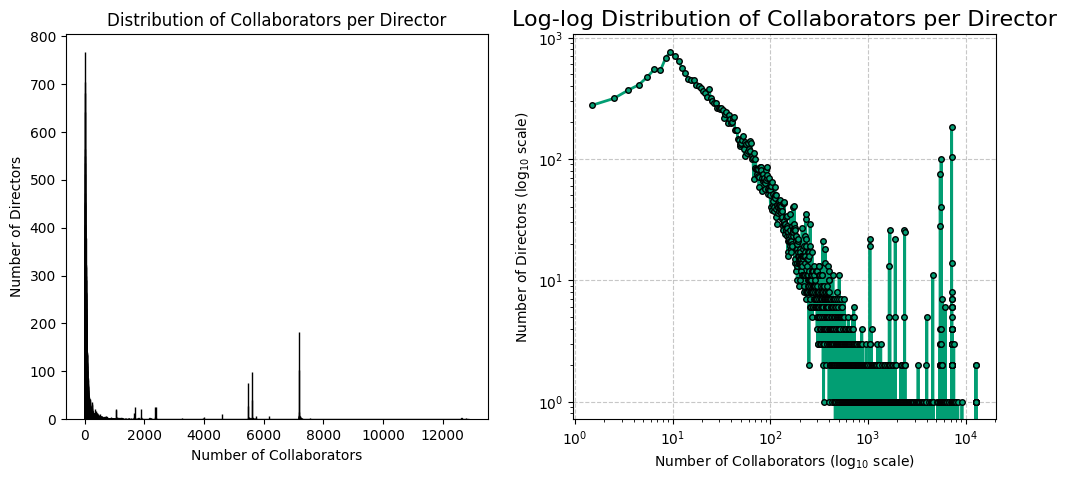

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2), edgecolor='black',color=PALETTE_D[1])
plt.xlabel('Number of Collaborators')
plt.ylabel('Number of Directors')
plt.title('Distribution of Collaborators per Director')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(collab_counts_df['NumCollaborators'], bins=range(1, max(collab_counts_df['NumCollaborators']) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Number of Collaborators (log$_{10}$ scale)')
plt.ylabel('Number of Directors (log$_{10}$ scale)')
plt.title('Log-log Distribution of Collaborators per Director', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.tight_layout()
plt.show();

We have a minority of directors that directed a huge number of films and thus had a huge number of collaborations throughout their career.
Let's see if this behaviour reproduces for the size of the movie crew :

In [27]:
def get_movie_crew_size(movies,matched_people) :
    """ 
    Retrieves the movie crew size for selected movies.

    Args : 
        movies : The dataframe containing information about our selected movies,
        matched_people : The IMDb 'basics' dataframe mapped for the people in our selected movies only.

    Returns :
        final_movies : A copy of the 'movies' dataframe passed as argument with an additional column containing the crew size of the movie.
    """
    #Retrieving all roles played by the individuals of the matched_people dataframe, taking the union on both to not count a movie twice
    crew = matched_people.copy()
    crew['knownForTitles'] = crew['knownForTitles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    crew['all_known_roles'] = crew['all_known_roles'].apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    roles_union_df = crew[['knownForTitles', 'all_known_roles']].apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)

    # Appropriate merges to return a modified version of the 'movies' dataframe
    roles_union_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_union_df})
    roles_union_df = roles_union_df.explode('roles_union')
    merged_df = pd.merge(movies, roles_union_df, left_index=True, right_on='roles_union')
    crew_sizes = pd.DataFrame(merged_df.groupby('roles_union')['nconst'].nunique())
    crew_sizes.rename(columns={'nconst': 'crew_size'},inplace=True)
    final_movies = pd.merge(movies,crew_sizes,left_index=True, right_index=True, how='left')

    return final_movies

We apply this function to our movies : (~1-2mins to run)

In [28]:
movies_wcs = get_movie_crew_size(movies,mip_enhanced)

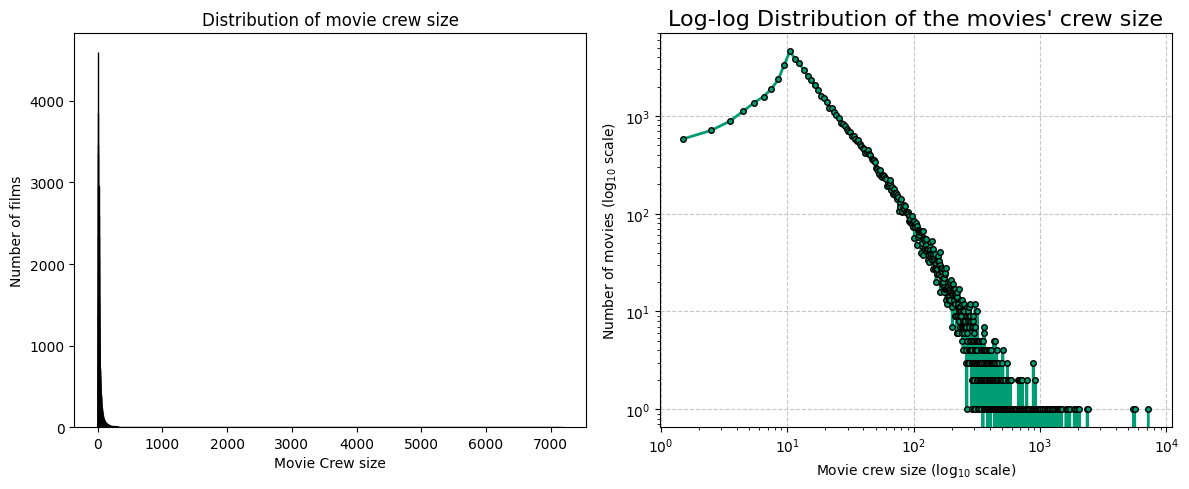

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2), edgecolor='black')
plt.xlabel('Movie Crew size')
plt.ylabel('Number of films')
plt.title('Distribution of movie crew size')

plt.subplot(1, 2, 2)
hist, edges = np.histogram(movies_wcs['crew_size'], bins=range(1, int(max(movies_wcs['crew_size'])) + 2))
bin_centers = 0.5 * (edges[:-1] + edges[1:])
plt.loglog(bin_centers, hist, 'o-', color=PALETTE_D[1], markeredgecolor='black', linewidth=2, markersize=4)
plt.xlabel('Movie crew size (log$_{10}$ scale)')
plt.ylabel('Number of movies (log$_{10}$ scale)')
plt.title('Log-log Distribution of the movies\' crew size', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

How are our movie scores distributed ?

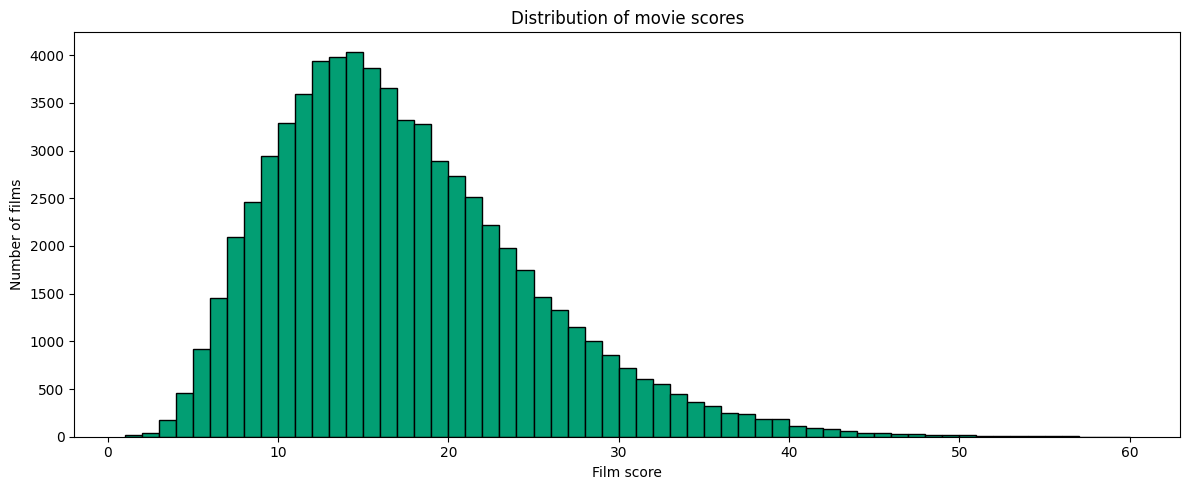

In [30]:
plt.figure(figsize=(12, 5))
plt.hist(movies['score'], bins=range(1, int(max(movies['score'])) + 2), color=PALETTE_D[1], edgecolor='black')
plt.xlabel('Film score')
plt.ylabel('Number of films')
plt.title('Distribution of movie scores')
plt.tight_layout()
plt.show()

Skewed, but not a power law.

Let us thus first see how the movie crew size is linked to the movie score :

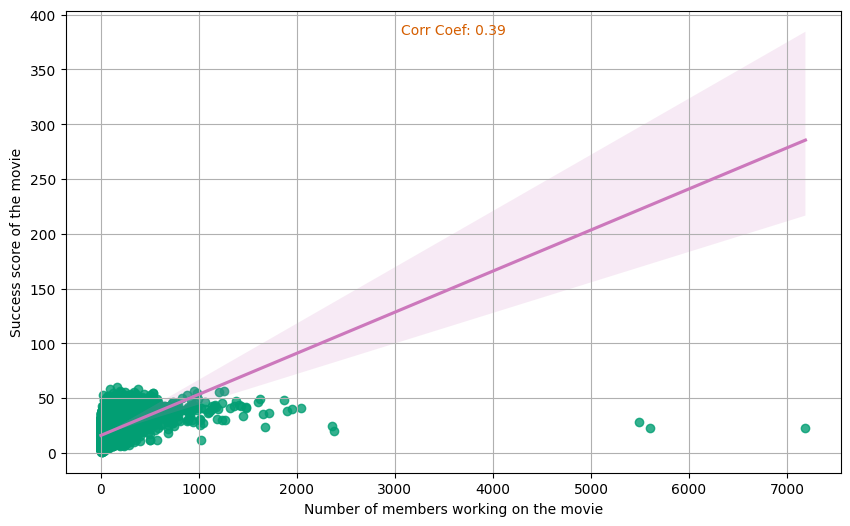

In [31]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wcs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wcs['crew_size'].corr(movies_wcs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

A few number of outliers with huge movie crewsizes : let's remove them to keep some reasonable crew sizes.

In [32]:
movies_wscs = movies_wcs[movies_wcs['crew_size'] < 3000]

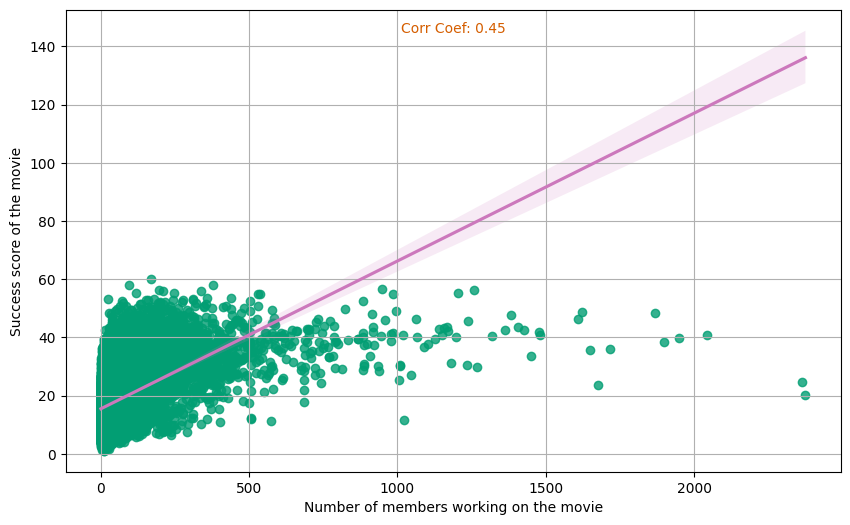

In [33]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='crew_size', y='score', data=movies_wscs, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = movies_wscs['crew_size'].corr(movies_wscs['score'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[4])
plt.title('')
plt.xlabel('Number of members working on the movie')
plt.ylabel('Success score of the movie')
plt.grid(True)
plt.show()

Difficult to assess the meaningfulness of the correlation between the size of the movie crew and the score of the movie. Let's display our first 10 movies in terms of score :

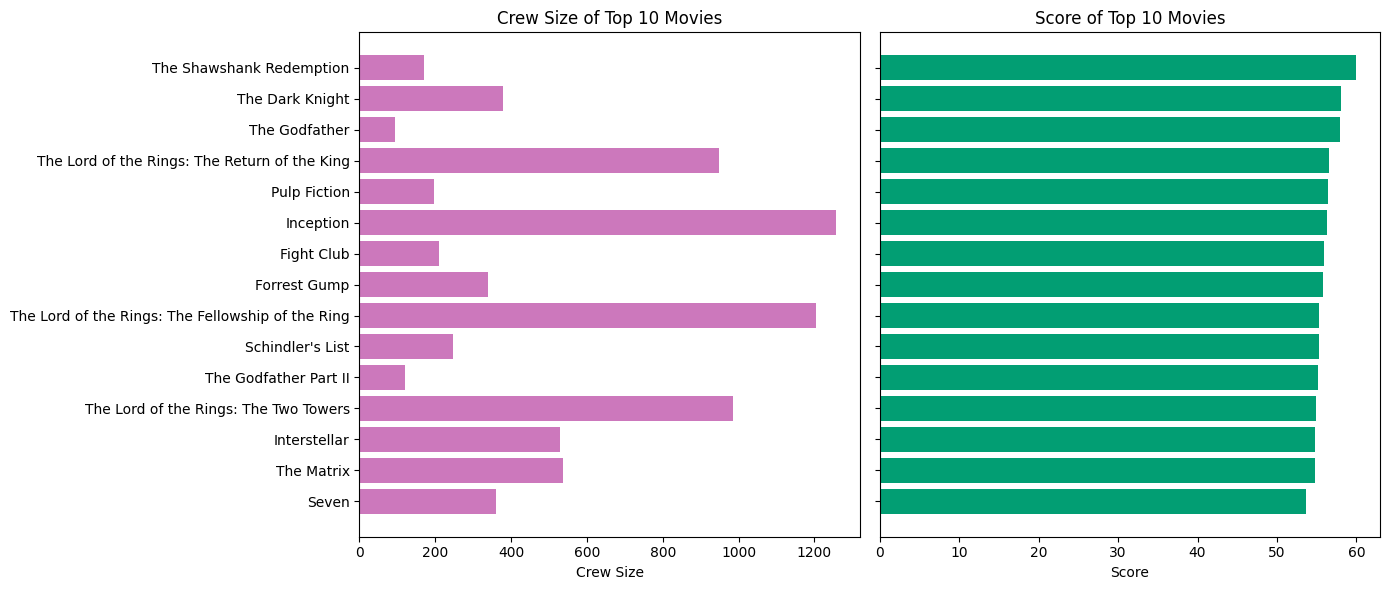

In [34]:
top_10_movies = movies_wscs.sort_values(by='score', ascending=False).head(15)
top_10_movies = top_10_movies.sort_values(by='score', ascending=True)

top_10_movies = top_10_movies.head(15)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot 1: Crew Size
ax1.barh(top_10_movies['title'], top_10_movies['crew_size'], color= PALETTE_D[0])
ax1.set_xlabel('Crew Size')
ax1.set_title('Crew Size of Top 10 Movies')

# Barplot 2: Score
ax2.barh(top_10_movies['title'], top_10_movies['score'], color=PALETTE_D[1])
ax2.set_xlabel('Score')
ax2.set_title('Score of Top 10 Movies')

plt.tight_layout()
plt.show()

We can just see that even amongst our most popular movies, we have the LOTR films & inception with a huge number of people who are credited, but actually the Godfather has a rather small crew size when compared to the latter.

If the impact on a certain movie is thus not really established, Let's try to see how the directors surround themselves for their movies : do they always have a huge number of people around them ?

In [35]:
enhanced_directors_df['directed_movies'] = enhanced_directors_df['directed_movies'].apply(lambda x: ','.join(x))

In [36]:
oui = enhanced_directors_df.copy(deep=True)

oui['directed_movies'] = oui['directed_movies'].apply(lambda x: str(x).split(','))

# Explode the lists to separate rows for each movie ID
directors_exploded = oui.explode('directed_movies')

merged_df = pd.merge(directors_exploded, movies_wcs, how='left', left_on='directed_movies', right_index=True)

# Filter for rows where the director has directed at least 3 movies
filtered_directors = merged_df.groupby('nconst').filter(lambda x: x['directed_movies'].nunique() >= 3)

# Calculate the average crew size for each director
average_crew_size = pd.DataFrame(filtered_directors.groupby('nconst')['crew_size'].mean())

average_crew_size.rename(columns={'crew_size' : 'avg_crew_size'},inplace=True)

enhanced_directors_df = pd.merge(enhanced_directors_df,average_crew_size,how='left',left_index=True,right_index=True)

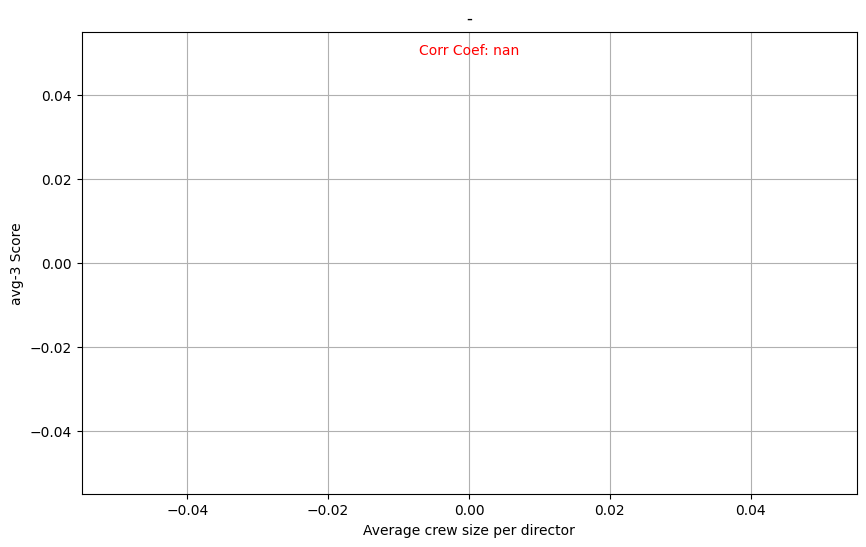

In [37]:
tmp_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3'])
tmp_df[['avg_crew_size', 'avg-3']] = tmp_df[['avg_crew_size', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=tmp_df, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = tmp_df['avg_crew_size'].corr(tmp_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew size per director')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

Interesting behaviour : seems like for averages inferior to a certain size there is a correlation between avg-3 score of the director and his/her average crew size but this is unbalanced when taking the movies superior to a certain size. Let's separate the directors in two to see how the two 'director' populations behave :

In [ ]:
large_crew_directors = tmp_df[tmp_df['avg_crew_size'] >= 300]
small_crew_directors = tmp_df[tmp_df['avg_crew_size'] < 300]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# For small crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=small_crew_directors, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]}, ax=axes[0])
correlation_coefficient = small_crew_directors['avg_crew_size'].corr(small_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color=PALETTE_D[2])
axes[0].set_title('Directors with Fewer than 300 Crew Members on average')

# For large crew dirs
ax = sns.regplot(x='avg_crew_size', y='avg-3', data=large_crew_directors, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]}, ax=axes[1])
correlation_coefficient = large_crew_directors['avg_crew_size'].corr(large_crew_directors['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
axes[1].set_title('Directors with 300 or More Crew Members on average')


fig.suptitle('Scatter Plot of Average Crew Size vs. avg-3 Score for Directors')
for ax in axes:
    ax.set_xlabel('Average Crew Size')
    ax.set_ylabel('avg-3 Score')

plt.tight_layout()
plt.show()

To see where the 'shift' happens, let's try and plot the evolution of the correlation coefficient of the avg-3 score with the size of the movie crew :

In [ ]:
correlation_dict = {}

threshold_values = range(0, 3000, 1)
max_correlation_coefficient = 0
optimal_threshold = 0

#iterating over the threshold values to get the correlation coefficients, each time
for threshold in threshold_values:
    
    selected_directors = tmp_df[tmp_df['avg_crew_size'] <= threshold]

    correlation_coefficient = selected_directors['avg_crew_size'].corr(selected_directors['avg-3'])


    correlation_dict[threshold] = correlation_coefficient

    if correlation_coefficient > max_correlation_coefficient:
        max_correlation_coefficient = correlation_coefficient
        optimal_threshold = threshold

# Extract the lists of thresholds and correlation coefficients
thresholds = list(correlation_dict.keys())
correlation_coefficients = list(correlation_dict.values())

plt.plot(thresholds, correlation_coefficients, marker='o', markersize=0.05,color=PALETTE_D[1], label='Correlation Coefficient')
plt.scatter(optimal_threshold, max_correlation_coefficient, color=PALETTE_D[4], s=10, label=f'Max Correlation\nThreshold={optimal_threshold}')
plt.xlabel('Maximum value of the average crew size considered')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient vs Threshold for avg_crew_size')
plt.legend()
plt.grid(True)
plt.show()

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Max Correlation Coefficient: {max_correlation_coefficient}')

Starting from a crew size of approximately 400, there starts to be a decrease in correlation between the average crew size of the director and its success. Could mean that too many members on seevral movie crews for a director can be detrimental to the success of directors.

That's an interesting conclusion : the crew size of the movie does not necessarily matter for a specific movie : very successful movies have both had crew sizes that are inferior to the 'threshold' we just found and very well above while still being successful. However, it seems that for directors that always work with a huge crew, the director's success gets impacted.

Nolan for instance indeed had a crew of 1200+ people on inception, but looking at his other films :


In [ ]:
top_nolan_movies = movies_wscs[movies_wscs['directors'].str.contains('nm0634240')].sort_values(by='score', ascending=False).head(10)
top_nolan_movies = top_nolan_movies.sort_values(by='score', ascending=True)

top_nolan_movies = top_nolan_movies.head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Barplot 1: Crew Size
ax1.barh(top_nolan_movies['title'], top_nolan_movies['crew_size'], color=PALETTE_D[0])
ax1.set_xlabel('Crew Size')
ax1.set_title('Crew Size of Top 10 Movies')

# Barplot 2: Score
ax2.barh(top_nolan_movies['title'], top_nolan_movies['score'], color=PALETTE_D[1])
ax2.set_xlabel('Score')
ax2.set_title('Score of Top 10 Movies')

# Display the plots
plt.tight_layout()
plt.show()

It's not something that necessarily repeats. Even among some of his most prestigious films, the crew size is not larger than 400 people, which is approximately the average crew size theshold we saw earlier where there really starts to be a decrease in correlation between director's success and avg crew size.


**--> Does the crew size has an impact on the success of a movie ?** : In absolute, no. There is of course going to be very few movies with extremely limited crew sizes that are as famous as the hollywood ones, but that's probably just cofounded by the budget of the movie or other elements that effect how this crew can be built.

**--> Does the crew size of the different movies of a director have an impact on its success ?** There is a clear relationship between a director's success and its crew sizes, that's worsening as much as the average crew size of a director evolves. It's for sure not the only factor impacting, but it does not play in favour of the directors.

Nuance : We still have a very vew numbers of directors with relatively big (>300) movie crews on average, because as we saw both the number of collaborations & movie crew sizes follow rather closely a power law, which makes sense, so it's also a matter of distribution.

---
## Are the directors who always work with the same crew more successful?

Now, let's try to see what's the behaviour of the number of collaborations of each director's. How many directors tend to work with similar people across their directed movies ? 

Quick function that retrieves all the persons that starred in some movies :

In [ ]:
def get_movie_crew(movies,matched_people) :
    

    #The beginning of the function is really similar to get_movie_crew_size, but the rest of the operation differ as it performs a matching to retrieve the crew of each specific
    #movie
    crew = matched_people.copy()
    tqdm.pandas(desc="knownForTitles under str form")
    crew['knownForTitles'] = crew['knownForTitles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())
    tqdm.pandas(desc="all_known_roles under str form")
    crew['all_known_roles'] = crew['all_known_roles'].progress_apply(lambda x: set(x.split(',')) if isinstance(x, str) else set())

    tqdm.pandas(desc="Taking union of knownForTitles & all_known_roles")
    roles_df = crew[['knownForTitles', 'all_known_roles']].progress_apply(lambda row: row['knownForTitles'].union(row['all_known_roles']), axis=1)
    roles_df = pd.DataFrame({'nconst': crew['nconst'], 'roles_union': roles_df})
    #roles_df = roles_df.explode('roles_union')

    tt_nconst_mapping = {}
    selected_movies = set(movies.index)
    #Itering through each row and update the dictionary created just above
    rows = []
    for index, row in tqdm(roles_df.iterrows(), total=len(roles_df), desc="Finding crew members", leave=False):
        nconst_id = row['nconst']
        tt_ids = row['roles_union']

        for tt_id in tt_ids:
            if tt_id in selected_movies:
                rows.append({'nconst': nconst_id, 'roles_union': tt_id})

    roles_df = pd.DataFrame(rows)

    # Group by 'roles_union' and aggregate 'nconst' as a list
    tt_nconst_mapping = roles_df.groupby('roles_union')['nconst'].agg(list).to_dict()

    return tt_nconst_mapping

In [ ]:
movie_crews = get_movie_crew(movies_wcs,mip_enhanced)

What we do here is we want to measure how directors change their crew overtime. We thus use the Overlap coefficient to measure the changes : It's the intersection of the crews divided by the size of the minimum of the two crews. We take the minimum here because we don't want to penalize the computations if the crew sizes are too different, what interests us here is just to know, overall, how much the directors keep people from one movie to the other. If all the people from movie 1 are moved to movie 2, even if movie 2 has more people, will yield a coefficient of 1, which is good because we want to maximize these kind of events as we do not have extensive information about the entire crews.

In [ ]:
def overlap_coefficient(set1, set2):
    intersection_size = len(set1.intersection(set2))
    min_size = max(len(set1), len(set2))
    return intersection_size / min_size if min_size > 0 else 0


enhanced_directors_df = enhanced_directors_df.dropna(subset=['avg_crew_size', 'avg-3'])
directors_copy = enhanced_directors_df.copy(deep=True)
directors_copy['avg_crew_change'] = 0.0 


for index, row in tqdm(directors_copy.iterrows(), total=len(directors_copy), desc="Finding crew similarities for the directors", leave=False) :
    director_id = index
    directed_movies = row['directed_movies'].split(',')

    # Get the set of crew members for each movie directed by the director
    director_crews = [set(movie_crews[movie_id]) for movie_id in directed_movies if movie_id in movie_crews]

    # Calculate crew changes
    crew_changes = []
    for i in range(len(director_crews) - 1):
        for j in range(i + 1, len(director_crews)):
            overlap_coeff = overlap_coefficient(director_crews[i], director_crews[j])
            crew_changes.append(overlap_coeff)

    # Calculate the average crew change for the director
    avg_crew_change = sum(crew_changes) / len(crew_changes) if crew_changes else 0
    directors_copy.at[index, 'avg_crew_change'] = avg_crew_change

We must however be careful that the measure biased because of the fact that we lack information for some directors. Maybe they had more than 7 people in their crew on average, but IMDb does not provide the rightful information about it.

Let's try, therefore, to only consider the ones with a sufficient crew size.

In [ ]:
directors_copy = directors_copy.dropna(subset=['avg_crew_change', 'avg-3']).copy()
directors_copy[['avg_crew_change', 'avg-3']] = directors_copy[['avg_crew_change', 'avg-3']].apply(pd.to_numeric, errors='coerce')
directors_copy = directors_copy[directors_copy['avg_crew_size'] > 20]
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='avg_crew_change', y='avg-3', data=directors_copy, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]})

correlation_coefficient = directors_copy['avg_crew_change'].corr(directors_copy['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average crew similarity (Overlap Coefficient)')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [ ]:
directors_copy = directors_copy.dropna(subset=['avg_crew_change', 'avg-3']).copy()

# Convert columns to numeric (if not already numeric)
directors_copy[['avg_crew_change', 'avg-3']] = directors_copy[['avg_crew_change', 'avg-3']].apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 6))

# Plot distribution of 'avg-3' score with respect to average crew similarity
ax = sns.histplot(y='avg-3', x='avg_crew_change', data=directors_copy, bins=100, cmap=PALETTE_C, cbar=True, fill=True)

plt.title('Distribution of avg-3 Score with respect to Average Crew Similarity')
plt.ylabel('avg-3 Score')
plt.xlabel('Average Crew Similarity (Overlap Coefficient)')
plt.grid(True)
plt.show()

If we consider the entire crews, it seems that the majority of directors tend to change crews between movies. The majority of directors have average scores in the 15-30 range with overlap coefficients from 0 to 0.05, hence seemingly changing crews in between films.

Moreover, the most successful directors also have rather low overlap coefficients. From this alone, it seems like directors, whatever their success is, tend do change crews in between movies.

In [ ]:
directors_copy.sort_values(by='avg_crew_change',ascending=False).head(10)

Most likely, yes. It's easier to get an overlap coefficient that is big if you have a very small number of collaborations on each film and you always work with nearly the same one(s). What this overlap coefficient rather indicates is that directors with large crews will unevitabely suffer changes from one film to the other, but we can not really assess the impact of these changes on director's success with this overlap coefficient alone. 

**Are the directors who always work with the same crew more successful?** --> If we take the entirety of the crew, then it does not seem that directors that keep their entire crew are most successful, graphs even tend to show the opposite. However, due to the lack of solid IMDb data with respect to the exact entire crews, it may be scuffed.

------
## Is directors' success related to the presence of certain individuals in their team ? If yes, how frequently have they been collaborating with each other ?

What is maybe more interesting is, instead of looking at the entirety of the crew, to see how much directors tend to keep some 'elements' of their crew : what we could consider as their core crew members. Maybe one, two or more people that are constantly there in between films. This helps, in contrary to the overall overlap coefficient, to assess the impact of particular relationships.

We will very simply try to check this by searching for the members that are present in the director's films. First, let's see how many directors had relationships with people that they maintained during at least 80% of the films they directed and that we have information about :


In [ ]:
def identify_core_crew(directors_copy, movie_crews, movies, success_threshold, core_threshold, only_successes):
    if only_successes :
        directors_with_at_least_threshold_movies = directors_copy[directors_copy['directed_movies'].apply(lambda x: len(str(x).split(',')) >= success_threshold)]
    else :
        directors_with_at_least_threshold_movies = directors_copy
    directors_core = directors_with_at_least_threshold_movies.copy()
    directors_core['core_crew'] = None

    for index, row in tqdm(directors_core.iterrows(), total=len(directors_core), desc=f"Identifying core members in directors' films (Threshold: {core_threshold*100} %)"):
        director_id = index
        directed_movies_str = row['directed_movies']

        directed_movies = directed_movies_str.split(',')

        if only_successes :
            top_movies_count = min(success_threshold, len(directed_movies))
        
        else :
            top_movies_count = len(directed_movies)

        top_movies = (
            pd.DataFrame(directed_movies, columns=['tconst'])
            .merge(movies[['score']], left_on='tconst', right_index=True)
            .nlargest(top_movies_count, 'score')
        )

        director_crews = [set(movie_crews[movie_id]) for movie_id in top_movies['tconst'] if movie_id in movie_crews]

        total_movie_count = len(top_movies)
        all_crew_members = [crew_member for crew_set in director_crews for crew_member in crew_set if crew_member != director_id]
        crew_member_counts = Counter(all_crew_members)

        core_crew = [crew_member for crew_member, count in crew_member_counts.items() if count >= core_threshold * total_movie_count]

        directors_core.at[index, 'core_crew'] = core_crew
    
    return directors_core

In [ ]:
dir_core = identify_core_crew(directors_copy,movie_crews,movies,100,0.8,False)
dir_core['core_crew_count'] = dir_core['core_crew'].apply(lambda x: len(str(x).split(',')) if x else 0)
dir_core.sort_values(by='avg-5',ascending=False).head(20)

Well, once again, we see that there are changes in crew members across the films : Only the Cohen Brothers have a core relationship, but it is of course with each other. There is nothing much to analyse here.

Rather, we're interested about **success** of the directors. Let us thus see if some persons are often present in their successes :

Here, we take the 5 best films (in terms of score) of the directors and identify if some crew members were present in at least 4 of them. 

In [ ]:
directors_core = identify_core_crew(directors_copy,movie_crews,movies,5,0.8,True)

directors_core['core_crew_count'] = directors_core['core_crew'].apply(lambda x: len(str(x).split(',')) if x else 0)
directors_core.sort_values(by='avg-5',ascending=False).head(10)

Now, that's more like it ! We have some 'core relationships'. However, results are mixed. Some of the most successful directors indeed have some very close relationships, but some do not. It however seems that the 'core_crew' size is either way pretty reduced. One exception shown above is Peter Jackson, which is normal as LOTR is a trilogy with essentially the same people working on it each time.

But interesting results here still :

- Nolan & Fincher : Their wives are in these core relationships

- Spielberg & Miyazaki (for instance) : Some famous composers : John Williams and Joe Hisaishi 

- Cohen Brothers : They of course share the same core crew members

From this only, the 'landscape' of core relationships seems complex to analyse. Let's see if the number of these core relationships has an impact on the score. We drop outliers such as Peter Jackson to have an better insight.

In [ ]:
test = directors_core[directors_core['core_crew_count'] < 50].dropna(subset=('avg-5','core_crew_count'))
test['avg-5'] = pd.to_numeric(test['avg-5'])
model = smf.ols('Q("avg-5") ~ core_crew_count', data=test).fit()
print(model.summary())

The R^2 squared is terrible, but slight (significant) positive correlation between the number of core relationships and the success metric of the director. 
From this simple model, it seems that the nb of close relationships of directors with members of the industry over their best films seem to have a slight correlation with success. 

To have more insights, we take a look at the difference in core crew relationships following certain thresholds of success score of directors.

In [ ]:
ouep = test.copy(deep=True)
ouep['avg-5'] = pd.to_numeric(ouep['avg-5'], errors='coerce')


def update_plot(threshold):
    
    ouep['Score Category'] = pd.cut(ouep['avg-5'], bins=[-float('inf'), threshold, float('inf')],
                                    labels=['<25', '>25'], right=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='Score Category', y='core_crew_count', data=ouep, errorbar=('ci', 95),color=PALETTE_D[1])

    # Set plot labels and title dynamically
    plt.xlabel(f'Success score Category (Threshold = {threshold:.2f})')
    plt.ylabel('Average core_crew_count')
    plt.title(f'Average core_crew_count for Directors (Threshold = {threshold:.2f})')

    # Update x-axis labels dynamically
    plt.xticks(ticks=plt.xticks()[0], labels=[f'<{threshold:.2f}', f'>{threshold:.2f}'])

    # Show the plot
    plt.grid(True)
    plt.show()

# Create an interactive slider for the threshold value
threshold_slider = widgets.FloatSlider(value=30, min=20, max=40, step=1,
                                      description='Threshold')
# Create the interactive plot
interact(update_plot, threshold=threshold_slider)


Although that of course does not mean causation, there seems to be a difference in core relationships number between successful directors and those that are not, whatever we decide to set the 'threshold' for success at.

However, let us be sure that this is not cofounded by the number of movies directed by a certain director : maybe it could just be that directors that directed more movies are more successful overall ?

We will balance the dataset with similar number of movies directed :


In [ ]:
control_df = test[test['avg-5'] < 30]
treatment_df = test[test['avg-5'] >= 30]
print(len(treatment_df), 'directors that are successful (treatment group).')
print(len(control_df), 'directors that are not successful (control group).')

~5mins to run

In [ ]:
G = nx.Graph()
for treatment_id, treatment_row in treatment_df.iterrows():
    for control_id, control_row in control_df.iterrows():
        nmd_similarity = np.abs(len(treatment_row['directed_movies'].split(',')) - len(control_row['directed_movies'].split(',')) )
        G.add_weighted_edges_from([(control_id, treatment_id, nmd_similarity)])
        
matching = nx.min_weight_matching(G)

In [ ]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
matched_test = test.loc[matched]
len(matched_test)

In [ ]:
# Make a copy of the DataFrame
ouep = matched_test.copy()

# Convert 'avg-5' column to numeric
ouep['avg-5'] = pd.to_numeric(ouep['avg-5'], errors='coerce')

# Function to update and plot based on the threshold value
def update_plot(threshold):
    # Create a new column to categorize directors based on the condition
    ouep['Score Category'] = pd.cut(ouep['avg-5'], bins=[-float('inf'), threshold, float('inf')],
                                    labels=['<25', '>25'], right=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.pointplot(x='Score Category', y='core_crew_count', data=ouep, errorbar=('ci', 95),color=PALETTE_D[1])

    # Set plot labels and title dynamically
    plt.xlabel(f'Success score Category (Threshold = {threshold:.2f})')
    plt.ylabel('Average core_crew_count')
    plt.title(f'Average core_crew_count for Directors (Threshold = {threshold:.2f})')

    # Update x-axis labels dynamically
    plt.xticks(ticks=plt.xticks()[0], labels=['Unsuccessful', 'Successful'])

    # Show the plot
    plt.grid(True)
    plt.show()

# Create an interactive slider for the threshold value
threshold_slider = widgets.FloatSlider(value=30, min=20, max=40, step=1,
                                      description='Threshold')
# Create the interactive plot
interact(update_plot, threshold=threshold_slider)

The difference and no-overlap of the 95CI% intervals is still present afterwards ! A statistical test to further check it :

In [ ]:
t_statistic, p_value = ttest_rel(matched_test[matched_test['avg-5'] <30]['core_crew_count'], matched_test[matched_test['avg-5'] >=30]['core_crew_count'])

print("T-statistic:", t_statistic)
print("P-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("The difference in accuracy is statistically significant.")
else:
    print("The difference in accuracy is not statistically significant.")

The difference between our two balanced groups is still statistically significant ! There is a significant difference in members in the core crew between successful directors and unsuccessful directors. Even when matching for the number of movies directed, the null hypothesis that the average core crew size between successful and unsuccessful directors most likely cannot only be explained by chance.

Now, the number of core relations is one thing, but what can be interesting to see is if the 'type' of people in this core crew has an impact as well. Do directors that have writers in their core crew have more success ? What about artistic/visual effects leads ? Even actors or actresses ?

How is success of directors related to the professions of people in their core crew ? (We one-hot encode variable for profession, 0 if the profession is not part of the core crew of the director, 1 if it is) ~4mins to run

In [ ]:
mip = mip_enhanced.set_index('nconst')
result_df = pd.DataFrame()

# Iterate through each row in directors_core dataframe
for index, row in tqdm(test.iterrows(), total=len(test)):
    director_id = index
    core_crew_list = row['core_crew']

    # Find the corresponding rows in mip_enhanced
    crew_member_rows = mip[mip.index.isin(core_crew_list)]
    # Flatten and unique list of professions
    professions = crew_member_rows['primaryProfession'].str.split(',').explode().unique()

    # Create a temporary dataframe for the current director
    temp_df = pd.DataFrame({'nconst': director_id}, index=[0])
    # Create binary columns indicating presence of each profession
    for profession in professions:
            if pd.notna(profession):
                cleaned_profession = ''.join(e for e in profession if e.isalnum())
                temp_df[cleaned_profession] = int(1)

    # Append the temporary dataframe to the result dataframe
    result_df = pd.concat([result_df, temp_df], ignore_index=True)

# Fill NaN values with 0
result_df = result_df.fillna(int(0))

final_result = pd.merge(test, result_df, on='nconst', how='left')

In [ ]:
# Sum the values in each column
#result_df = result_df.set_index('nconst')
profession_counts = result_df.sum()


# Set the presence threshold
presence_threshold = 0.02

# Identify professions with at least the specified presence
filtered_professions = profession_counts[profession_counts / profession_counts.sum() >= presence_threshold]
others = profession_counts[profession_counts / profession_counts.sum() < presence_threshold]

sorted_profession_counts = profession_counts.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 8))
color_mapping = dict(zip(filtered_professions.index, PALETTE_D + ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']))


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot the bar chart on the first subplot
ax1.bar(sorted_profession_counts.index, sorted_profession_counts, color=[color_mapping.get(label, 'lightgray') for label in sorted_profession_counts.index])

ax1.set_title('Distribution of Professions in Core Crew of Directors', fontsize=14)
ax1.set_xlabel('Professions')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=90)

# Plot the pie chart on the second subplot
combined_profession_counts = filtered_professions.copy()
combined_profession_counts['other'] = others.sum()

# Plot the pie chart
ax2.pie(combined_profession_counts, labels=combined_profession_counts.index, autopct='%1.1f%%', colors=[color_mapping.get(label, 'lightgray') for label in combined_profession_counts.index])

# Customize the appearance of the pie chart
ax2.set_title('Percentage of Professions in Core Crew', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

The three professions that are the most present in the core crew of directors are producers, writers, as well as actors. At 4th, we can also see that ~9% of the directors we selected have collaborated pretty closely with other directors.
Then, we also have professions in the 'sound' domain : soundtrack, musicdepartment & composer namely, which are also present to a certain extent in the director's crews.

Interestingly, actresses are way less presents than actors : sign of a man-dominated industry.

Cinematographers are also present.

We then have also a lot of others but that are present in extremely few quantity : we cannot draw any conclusions using them on the success of a director that maybe have them in its crew. We only have 'famous' cinema jobs in these collaborations : all the shadow jobs do not seem well represented. However, this can also come from the lack of complete and throrough information on the complete crew of films. We only have what's more valorized through IMDb, this can be important to mention as a potential bias in our analysis of this part in particular.

However, we can take the main jobs present above and try to see if some of them are more linked with director's success : Producer, Writer, Actor, Director, Soundtrack, MusicDepartment, Composer, Cinematographer, Cameradepartment, AssistantDirector and editiorialdepartment.


In [ ]:
ml_df = pd.merge(directors_core['avg-5'], result_df, left_index=True,right_index=True)

In [ ]:
# Convert 'avg-5' to numeric type
ml_df['avg-5'] = pd.to_numeric(ml_df['avg-5'], errors='coerce')

filtered_data = ml_df[['avg-5', 'producer', 'writer', 'actor', 'director', 'soundtrack','musicdepartment','composer', 'cinematographer','cameradepartment','editor','editorialdepartment', 'assistantdirector', 'actress', 'productionmanager']]

avg_scores = {}
for profession in filtered_data.columns[1:]:
    avg_score = filtered_data[filtered_data[profession] == 1.0]['avg-5'].mean()
    avg_scores[profession] = avg_score

data_for_analysis = pd.DataFrame(columns=['Profession', 'avg-5'])
for profession in avg_scores.keys():
    data_for_analysis = pd.concat([data_for_analysis, filtered_data[filtered_data[profession] == 1.0][['avg-5']].assign(Profession=profession)])

# Perform Tukey's HSD test for multiple comparisons !!
tukey_results = pairwise_tukeyhsd(data_for_analysis['avg-5'], data_for_analysis['Profession'], alpha=0.05)

# Plot the results
plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(8, 4))
sns.barplot(x=list(avg_scores.keys()), y=list(avg_scores.values()),color=PALETTE_D[1])

# 95CI barssss
for i, profession in enumerate(avg_scores.keys()):
    ci = tukey_results.meandiffs[i]
    plt.errorbar(i, avg_scores[profession], yerr=abs(ci), fmt='none', color='black', capsize=5)

# Stars for significant differences
for i, pvalue in enumerate(tukey_results.pvalues < 0.05):
    if pvalue:
        plt.text(i, max(avg_scores.values()) + 0.15, '*', ha='center', va='center', fontdict={'weight': 'bold'})

plt.xlabel('Profession')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average avg-5 Score')
plt.title('Average avg-5 Score for Selected Professions with 95% CI and Significant Differences')
plt.show()

No significant differences between any of the professions in terms of the avg-5 score, in the core crew of the director.

--> The type of people in the core crew is not sufficient to explain the success : chemistry is something else than association of jobs !

-----
### Are some directors successful only because they cast popular actors ?

In [ ]:
actors_and_actresses = pd.DataFrame(jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])]['nconst'].unique()).rename(columns={0:'nconst'})

# Count the number of movies for each actor in jobs_principal_people
actor_movie_counts = jobs_principal_people[jobs_principal_people['category'].isin(['actor', 'actress'])].groupby('nconst')['tconst'].count()

# Filter out actors who have less than 3 movies
valid_actors_initial = actor_movie_counts[actor_movie_counts >= 3].index

In [ ]:
#Getting the scores for each people and each movie
tmp_mip = mip_enhanced[mip_enhanced['nconst'].isin(valid_actors_initial)].copy()
tmp_mip = pd.merge(tmp_mip,actors_and_actresses,on='nconst')
tmp_mip['known_titles_list'] = tmp_mip['knownForTitles'].str.split(',')
exploded_people_df = tmp_mip.explode('known_titles_list')
merged_df = pd.merge(exploded_people_df, movies, left_on='known_titles_list', right_index=True, how='left')
merged_df['score'] = pd.to_numeric(merged_df['score'], errors='coerce')

# Filter out NaN scores
merged_df_filtered = merged_df.dropna(subset=['score'])
# Calculate the number of movies per person, filter to keep only the ones with a sufficient number of movies played in
movie_count_per_person = merged_df_filtered.groupby('nconst')['score'].count()
valid_people = movie_count_per_person[movie_count_per_person >= 3].index
# Filter the merged dataframe for valid people
valid_merged_df = merged_df_filtered[merged_df_filtered['nconst'].isin(valid_people)]
# Calculate the number of movies per person in the original movies dataframe
movie_count_per_person_original = valid_merged_df.groupby('nconst').size()

# Filter out individuals with less than 3 movies in the original movies dataframe
final_valid_people = movie_count_per_person_original[movie_count_per_person_original >= 3].index

# Filter the merged dataframe for final valid people
final_valid_merged_df = valid_merged_df[valid_merged_df['nconst'].isin(final_valid_people)]

# Calculate the average score and primary name for each person
average_scores = final_valid_merged_df.groupby('nconst').agg({'score': 'mean', 'primaryName': 'first'})

In [ ]:
average_scores.sort_values(by = 'score',ascending=False).head(10)

We have a list of only actors/actresses that played in several movies being part of the main cast.

In [ ]:
actors_collabs = {director: {actoress: collaborations for actoress, collaborations in data.items() if actoress in average_scores.index} for director, data in collab_counts.items()}
actors_collabs = {director: data for director, data in actors_collabs.items() if director in directors_copy.index}

In [ ]:
actor_score_mapping = dict(zip(average_scores.index, average_scores['score']))

directors_avg_score = {}
for director, collaborations in actors_collabs.items():
    total_score = 0
    total_collaborations = 0
    for actor, collaborations_count in collaborations.items():
        if actor in actor_score_mapping:
            total_score += actor_score_mapping[actor] * collaborations_count
            total_collaborations += collaborations_count
    if total_collaborations >= 3:
        directors_avg_score[director] = total_score / total_collaborations

# Create a DataFrame for directors and their average scores
directors_df = pd.DataFrame(list(directors_avg_score.items()), columns=['director', 'average_score'])

# Merge the directors_df with our directors' success scores
merged_df = directors_df.merge(directors_copy, left_on='director', right_index=True)

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='average_score', y='avg-3', data=merged_df, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[0]})

correlation_coefficient = merged_df['average_score'].corr(merged_df['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Average score of the actors')
plt.ylabel('avg-3 score of the directors')
plt.grid(True)
plt.show()

There seem to be an increase --> then : Directors only successful because they cast successful actors ? 

But successful actors basically mainly works with successful directors... The chicken or the egg ?

Let's try to perform a graph between directors and actors only : We already suppressed people that are not lead actors/actresses from the equation and we also remove all potential links in between directors.

This way, we have a actors/actresses <--> directors bipartite graph. The number of nodes and edges is going to be huge, and to see how successful directors are similar in terms of successful actors/actresses they cast, we can use the bipartite projection of this graph on director's nodes.


In [ ]:
def building_bipartite_projection(collab_counts,wanted_directors,all_directors) :
    
    graph = nx.Graph()
    
    directors_set = set()
    collaborators_set = set()

    for director, collaborators in tqdm(collab_counts.items(),total=len(collab_counts),desc="Building a graph of all collaborations"):
        if director in wanted_directors :
            if director not in directors_set:
                graph.add_node(director, bipartite=0)
                directors_set.add(director)

            for collaborator, collaborations_count in collaborators.items():
                if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                    if collaborator not in collaborators_set:
                        graph.add_node(collaborator, bipartite=1)
                        collaborators_set.add(collaborator)

                    if collaborator not in collab_counts.keys() : 
                        if ((collaborator not in all_directors) & (collaborator not in wanted_directors)) :
                            graph.add_edge(director, collaborator, weight=collaborations_count)
    print('The Graph is Bipartite :', str(bipartite.is_bipartite(graph)))          
    directors_nodes = {node for node, data in graph.nodes(data=True) if data['bipartite'] == 0}
    directors_projection = nx.bipartite.weighted_projected_graph(graph, directors_nodes, ratio=False)

    return(graph, directors_nodes,directors_projection)

In [ ]:
actors_collab_graph, proj_directors_nodes, curr_act_dict_proj = building_bipartite_projection(actors_collabs,directors_copy.index,directors.index)

In [ ]:
plt.figure(figsize=(12,8))
subgraph = curr_act_dict_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(20).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')


# Draw the subgraph
scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C
norm = Normalize(vmin=global_min, vmax=global_max) 


# Normalize edge weights by dividing by the maximum weight
pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

# Map normalized values to colors using the colormap
node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')
label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)


plt.grid(False)
plt.gca().set_frame_on(False)
cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.set_label(cbar_label)
cbar.ax.set_ylim(global_min, global_max)
plt.show()

The most famous directors are hyper-connected in terms of collaborations they share with different actors. How does it evolve ?

In [ ]:
def plot_directors(start_index):
    plt.figure(figsize=(12,8))
    end_index = start_index + 20
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = curr_act_dict_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')

    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}

    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()

    cmap = PALETTE_C
    norm = Normalize(vmin=global_min, vmax=global_max)

    pos = nx.circular_layout(subgraph)
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    normalized_values = norm(node_colors)

    node_colors_mapped = [cmap(value) for value in normalized_values]

    node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
    nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)

    label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
    for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

    plt.grid(False)
    plt.gca().set_frame_on(False)
    cbar_label = 'Directors Success Score'
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.set_ylim(global_min, global_max)
    cbar.set_label(cbar_label)
    cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
    cbar.outline.set_visible(True)
    plt.show()

In [ ]:
for start_index in [20,60,100,400,1000,1500,2000,2500]:
    plot_directors(start_index)

As expected, the more 'unsuccessful' the directors are, the less connections they harbor with other directors. Some relationships might happen still, but generally the most 'full' graphs in terms of edges are found when successful directors are present.


Let's see intersting things for the most successful ones :

In [ ]:
common_keys = set(actors_collabs['nm0000631'].keys()) & set(actors_collabs['nm0000229'].keys())

# Find common items (key-value pairs)
common_items = set(actors_collabs['nm0000631'].items()) & set(actors_collabs['nm0000229'].items())

print("Common actor collaboration:", common_keys)

In [ ]:
average_scores.loc[list(common_keys)]

Ridley scott & Steven Spielberg share a lot of actors, and their score indicates, they majoritarely are successful actors, with very famous names such as DiCaprio, Harisson Ford, Anthony Hopkins, Tom Cruise amongst the most well known.

 Directors that, at first sight, even though both extremely brilliant seem to have nothing to have in common in terms of their universe and time in activity : Miyazaki & both Hitchock. They still have a common collaboration when looking at the graph above :

In [ ]:
common_keys = set(actors_collabs['nm0594503'].keys()) & set(actors_collabs['nm0000033'].keys())

# Find common items (key-value pairs)
common_items = set(actors_collabs['nm0594503'].items()) & set(actors_collabs['nm0000033'].items())

print("Common actor collaboration:", common_keys)

In [ ]:
average_scores.loc[list(common_keys)]

Suzanne Pleshette actually worked as a voice actress on the english version of Spirited Away but also stars a main role of 'The Birds' by Hitchcock. Of course, this is only a voice actor for the english version of the movie which may not have directly been by Miyazaki itself. However the choices surely have been made with Studio Ghibli, and it still shows that successful actors play a role in the success of the movies worldwide even for movies that come from overseas !


Connections are inevitable : we can see that in terms of actors, very successful directors have a tendency to be connected to each other in terms of actors/actresses they star in their films.

Now let's do the same thing, but for the entire collaborations that we have found, not only actors. One node per director and by person in the many different crews, the edge linking the both being weighted by their number of collaborations. The graph is once again constructed in such a manner that directors-directors (if two directors direct the same films) are not counted in the graph : ONLY crew-directors interactions --> bipartite graph.


Function is defined to build this bipartite projection for only the directors that we want (inclusion of 'all_directors' is to not add edges between two directors). (Takes ~10 mins to run)

In [ ]:
all_collab_graph, all_directors_nodes, all_bip_proj = building_bipartite_projection(collab_counts,directors_copy.index,directors.index)

The original graph, given its size and the number of edges, is useless to display : we can not really even see what it's all about. Let's thus look at what we obtain for the bipartite projection of our most successful directors :

In [ ]:
plt.figure(figsize=(12,8))
subgraph = all_bip_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(20).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')

scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C 
norm = Normalize(vmin=global_min, vmax=global_max) 

pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)

label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')

plt.gca().set_frame_on(False)
plt.grid(False)
cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.ax.set_ylim(global_min, global_max)
cbar.set_label(cbar_label)
plt.show()

Successful directors share relationships it seems! Let's try even bigger :

In [ ]:
plt.figure(figsize=(12,8))
subgraph = all_bip_proj.subgraph(directors_copy.sort_values(by='avg-3',ascending=False).head(40).index.to_list())
edge_weights = nx.get_edge_attributes(subgraph, 'weight')


# Draw the subgraph
scaler = MinMaxScaler(feature_range=(0.5, 4))
normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}


global_min = directors_copy['avg-3'].min()
global_max = directors_copy['avg-3'].max()

cmap = PALETTE_C   # Replace 'viridis' with your desired colormap
norm = Normalize(vmin=global_min, vmax=global_max) 


# Normalize edge weights by dividing by the maximum weight
pos = nx.circular_layout(subgraph)
edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
normalized_values = norm(node_colors)

# Map normalized values to colors using the colormap
node_colors_mapped = [cmap(value) for value in normalized_values]


node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)
#nx.draw_networkx_labels(subgraph, pos, labels=labels, font_weight='bold')
label_pos = {k: (v[0] + 0.25 * pos[k][0], v[1] + 0.15 * pos[k][1]) for k, v in pos.items()}

for node, (x, y) in label_pos.items():
            #print(x,y)
            # Increase y-coordinate for nodes at the top
            if y > 1.14:
                y += 0.05
            # Decrease y-coordinate for nodes at the bottom
            elif y < -1.14:
                y -= 0.05
            plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

plt.grid(False)

cbar_label = 'Directors Success Score'
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array for the data range
cbar = plt.colorbar(sm,ax=plt.gca())
plt.gca().set_frame_on(False)
cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
cbar.ax.set_ylim(global_min, global_max)
plt.show()

Seems like it works well, some relationships are way heavier than others depending on the similarities of the collaborations they had throughout their careers. Here we can see that the Wachovski sisters & the Cohen brothers have very much heavier links towards each other than with the rest (improve the visualization).
Overall however, these successful directors seem very well connected !

What about unsuccessful ones ?

In [ ]:
def plot_all_directors(start_index):
    plt.figure(figsize=(12,8))
    end_index = start_index + 40
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = all_bip_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')

    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}

    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()

    cmap = PALETTE_C
    norm = Normalize(vmin=global_min, vmax=global_max)

    pos = nx.circular_layout(subgraph)
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}

    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    normalized_values = norm(node_colors)

    node_colors_mapped = [cmap(value) for value in normalized_values]

    node_collection = nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors_mapped, node_size=100)
    nx.draw_networkx_edges(subgraph, pos, edge_color='black', width=edge_widths)

    label_pos = {k: (v[0] + 0.2 * pos[k][0], v[1] + 0.1 * pos[k][1]) for k, v in pos.items()}
    for node, (x, y) in label_pos.items():
        if y > 1.09 :
            y+=0.05
        if y <-1.09 :
            y-= 0.05
        plt.text(x, y, labels[node], ha='center', va='center', fontweight='light', fontsize=10)

    plt.grid(False)
    plt.gca().set_frame_on(False)
    cbar_label = 'Directors Success Score'
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  
    cbar = plt.colorbar(sm, ax=plt.gca())
    cbar.ax.set_ylim(global_min, global_max)
    cbar.set_label(cbar_label)
    cbar.ax.set_position([0.825, 0.1, 0.02, 0.8])
    cbar.outline.set_visible(True)
    plt.show()

In [ ]:
for start_index in [0,20,60,100,400,1000,1500,2000,2500]:
    plot_all_directors(start_index)

Much less shared collaborations between unsuccessful directors.

Very few relationships, looks nothing like what we saw above. There seems like there is a real difference : Unsuccessful directors have very few common crew members, while successful ones seems to be sharing a lot of them.

Therefore, In that bipartite graph, let's try to find the directors with the highest degree centrality : the ones that share most similarities with other directors in terms of different collaborations they had throughout their career. Are these only successful directors ? (this is only an idea, maybe the metric to retrieve is not the best)

In [ ]:
def retrieve_degree_centrality(graph):
    """
    Finds the directors with the highest degree centrality : the directors that are the most 'well-connected' to the rest of the network.
    """
    dcs = pd.Series(nx.degree_centrality(graph))
    return dcs

In [ ]:
dcs = retrieve_degree_centrality(all_bip_proj)
dcs = pd.DataFrame({'nm_id': dcs.index, 'degree_centrality': dcs.values})
dcs.set_index('nm_id', inplace=True)
directors_dc = pd.merge(directors_copy,dcs,left_index=True,right_index=True)

In [ ]:
directors_dc.sort_values(by='degree_centrality',ascending=False).head(10)

In [ ]:
model = smf.ols('Q("avg-3") ~ degree_centrality', data=directors_dc).fit()
print(model.summary())

Nice ! Directors displayed mainly contains directors that are successful to very successful, and the degree centrality is (significantly) correlated with the avg-3 score + R^2 is actually very decent for a single variable. Of course, the metric is not perfect as it can be easily rigged. However, it still shows that there is a singificant impact of the 'network' of relationships for directors : very successful directors definitely tend to 'share' collaborations : famous/successful people work with famous/successful people !


--> **Are some directors successful only because they cast popular actors ?** There is a clear relationship, when taking the graphs above, between the successful actors and directors. However, when taking the entirety of the crew jobs at once, we see that it's part of a bigger thing. It's part of the film industry network : successful people tend to work with successful people. Even if there is a clear correlation, the career success is even more linked to the introduction, at some point, of the director into this network.

In [ ]:
plot(global_fig, filename="interactive_subplot.html")

---
###  Extra :
How are both experience ( i.e how many movies people have directed / worked on etc.) & diversity in their career linked to movie success ?

In [ ]:
experience_info = enhanced_directors_df[['primaryName','primaryProfession','avg-3','directed_movies']]

In [ ]:
experience_info_filtered = experience_info.copy()
experience_info_filtered['num_movies_directed'] = experience_info_filtered['directed_movies'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

experience_info_filtered['avg-3'] = pd.to_numeric(experience_info['avg-3'], errors='coerce')
experience_info_filtered['num_movies_directed'] = pd.to_numeric(experience_info_filtered['num_movies_directed'], errors='coerce')
experience_info_filtered = experience_info_filtered.dropna(subset=['avg-3']) ## DROPPING THE NAN AVG-3 VALUE, MODIFY IF SCORE CHANGES

plt.figure(figsize=(10, 6))
ax = sns.regplot(x='num_movies_directed', y='avg-3', data=experience_info_filtered, scatter_kws={'color': PALETTE_D[1]}, line_kws={'color': PALETTE_D[4]})

correlation_coefficient = experience_info_filtered['num_movies_directed'].corr(experience_info_filtered['avg-3'])
ax.annotate(f'Corr Coef: {correlation_coefficient:.2f}', xy=(0.5, 0.95), xycoords='axes fraction', ha='center', fontsize=10, color='red')
plt.title('-')
plt.xlabel('Number of Movies Directed')
plt.ylabel('avg-3 Score')
plt.grid(True)
plt.show()

In [ ]:
unique_professions = set(','.join(experience_info_filtered['primaryProfession']).split(','))

# Create dummy variables for each unique profession
for profession in unique_professions:
    experience_info_filtered[profession] = experience_info_filtered['primaryProfession'].apply(lambda x: 1 if profession in x else 0)

# Filter and calculate mean 'avg-3' for directors who were also actors, producers, etc.
mean_avg3_by_profession = {}
for profession in unique_professions:
        if profession != 'director' :
            director_count = experience_info_filtered[experience_info_filtered[profession] == 1].shape[0]
            if director_count > 20:
                filtered_data = experience_info_filtered[experience_info_filtered[profession] == 1]
                mean_avg3_by_profession[profession] = filtered_data['avg-3'].mean()

# Sort values based on mean 'avg-3' scores
sorted_professions = sorted(mean_avg3_by_profession.items(), key=lambda x: x[1], reverse=True)

# Visualize the results
plt.figure(figsize=(8, 6))
plt.bar([item[0] for item in sorted_professions], [item[1] for item in sorted_professions], color=PALETTE_D[1])
plt.title('Mean avg-3 Score by Primary Profession')
plt.xlabel('Primary Profession')
plt.ylabel('Mean avg-3 Score')
plt.xticks(rotation=45, ha='right')
plt.show()

## Code for Interactive Plotly graphs displayed on the website

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as plc

def plot_all_directors(start_index):
    end_index = start_index + 40
    selected_directors = directors_copy.dropna(subset='avg-3').sort_values(by='avg-3', ascending=False).iloc[start_index:end_index]
    subgraph = all_bip_proj.subgraph(selected_directors.index.to_list())
    edge_weights = nx.get_edge_attributes(subgraph, 'weight')
    scaler = MinMaxScaler(feature_range=(0.5, 4))
    normalized_weights = scaler.fit_transform([[w] for w in edge_weights.values()])
    normalized_weights = {edge: weight[0] for edge, weight in zip(edge_weights.keys(), normalized_weights)}
    edge_widths = [normalized_weights[edge] for edge in subgraph.edges]

    # Create a Plotly figure
    fig = make_subplots()

    pos = nx.shell_layout(subgraph)

    labels = {node: directors.loc[node, 'primaryName'] for node in subgraph.nodes}
    node_colors = directors_copy.loc[list(subgraph.nodes), 'avg-3']
    global_min = directors_copy['avg-3'].min()
    global_max = directors_copy['avg-3'].max()
    norm = Normalize(vmin=global_min, vmax=global_max)
    normalized_values = norm(node_colors)
    seaborn_colors_rgba = [PALETTE_C(i) for i in range(256)]
    seaborn_colors_rgb = [f"rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})" for (r, g, b, _) in seaborn_colors_rgba]
    

    #node_colors_mapped = [seaborn_colors_rgba[int(value)] for value in normalized_values]
    node_colors_mapped = [seaborn_colors_rgb[int(value * 255)] for value in normalized_values]

    edge_traces = []

    for edge, width in zip(subgraph.edges(), edge_widths):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace = go.Scatter(
            x=[x0, x1, None],
            y=[y0, y1, None],
            line=dict(width=width, color='black'),
            hoverinfo='none',
            mode='lines'
        )
        edge_traces.append(edge_trace)
    
    fig.add_traces(edge_traces)
    
    node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale=seaborn_colors_rgb,
        cmin=global_min,
        cmax=global_max,
        size=10,
        colorbar=dict(
            thickness=15,
            title='Director Success Score',
            xanchor='left',
            titleside='right'
        ),
        #line=dict(width=2),
        color=node_colors_mapped
    ))

    for node, color in zip(subgraph.nodes(), node_colors_mapped):
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['text'] += tuple([f'Director: {labels[node]}<br>Score: {directors_copy.loc[node, "avg-3"]:.2f}'])
        #node_trace['marker']['color'] += tuple([color])

    fig.add_trace(node_trace)

    fig.update_layout(
        showlegend=False,
        hovermode='closest',
        height = 650,
        width = 750,
        margin=dict(b=0, l=0, r=0, t=0),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

    fig.show()
    html_file_name = f"interactive_plot_{start_index}.html"
    fig.write_html(html_file_name)

# Use the interact function to connect the sliders to the plot function
#interact(plot_all_directors, start_index=start_slider)

In [ ]:
start_slider = widgets.IntSlider(value=0, min=0, max=len(directors_copy)-40, step=200, description='Start Index:')

# Call the plot_all_directors function with the initial value
plot_all_directors(start_slider.value)

# Define a function to update the plot when the slider value changes
def update_plot(change):
    plot_all_directors(change.new)

# Connect the update_plot function to the slider's value change event
start_slider.observe(update_plot, 'value')

# Display the slider
display(start_slider)